<a href="https://colab.research.google.com/github/rajatrh/MTA-Schedule-Delays/blob/master/User_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from dateutil import tz
import math

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
df_crowd_source = pd.read_csv('/content/drive/My Drive/523 524/CrowdsourcingLocationLog.csv')

In [0]:
def convertToDate(dateTime):
  cur = pd.to_datetime(dateTime, errors='coerce')
  cur.tz_localize(None)
  return cur.date()

In [0]:
df_crowd_source['_created_at'] = df_crowd_source.apply(lambda x: convertToDate(x['_created_at']),axis=1)

In [44]:
df_crowd_source.shape

(1486295, 6)

In [45]:
df_crowd_source.head(1)

,userId,_created_at,locationTime,latitude,longitude,horizontalAccuracy
0,d97ea50e-6dff-40e8-93db-19205a19b976,2019-07-01,8:00:01 PM,40.741217,-73.637016,10.0


In [46]:
df_userCount = df_crowd_source.groupby('userId')['userId'].count().to_frame('count')
df_userCount.sort_values(by="count", ascending=False).head(3)

,count
userId,
615d12dc-e77c-4aef-a953-007249f8492e,18963
a1bb8718-6999-4892-95fb-66c4601fc891,16155
7f72fd31-0cbc-46cd-8c59-63928eb56ed5,15435


In [47]:
df_crowd_source[df_crowd_source['userId'] == '615d12dc-e77c-4aef-a953-007249f8492e'].groupby('_created_at').count()

,userId,locationTime,latitude,longitude,horizontalAccuracy
_created_at,,,,,
2020-01-04,187,187,187,187,187
2020-01-05,2803,2803,2803,2803,2803
2020-01-06,2264,2264,2264,2264,2264
2020-01-07,2813,2813,2813,2813,2813
2020-01-08,2816,2816,2816,2816,2816
2020-01-09,2725,2725,2725,2725,2725
2020-01-10,2822,2822,2822,2822,2822
2020-01-11,2533,2533,2533,2533,2533


In [0]:
df_user_date_count = df_crowd_source.groupby([
    pd.Grouper('userId'),
    pd.Grouper('_created_at')]
)['userId'].count().to_frame('count')

In [50]:
df_user_date_count.head(3)

count
userId                               _created_at       
0003476a-5cd9-4e3f-b180-208bbaf03363 2019-07-17      95
                                     2019-07-18      14
                                     2019-07-19     129

In [53]:
df_crowd_source['_created_at'].describe()

count        1486295
unique           214
top       2019-07-03
freq           47661
Name: _created_at, dtype: object

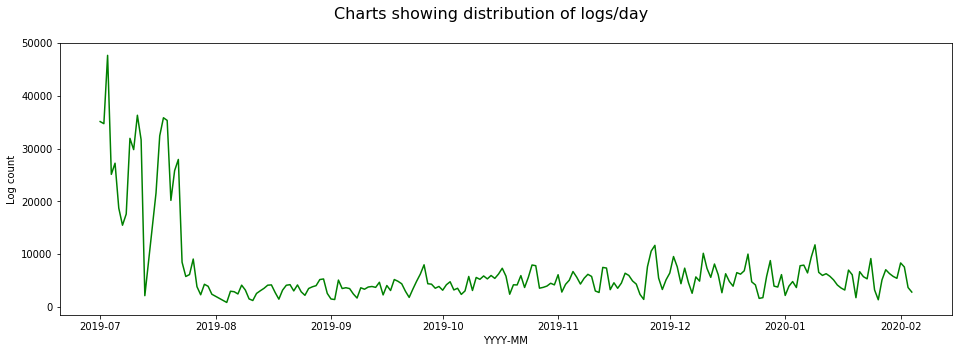

In [101]:
plt.figure(figsize=(16,5))
plt.suptitle('Charts showing distribution of logs/day'
, fontsize=16)
sb.lineplot(y='count_', x='_created_at', data=q2b, color='green')
plt.xlabel("YYYY-MM")
plt.ylabel("Log count")
plt.show()

In [0]:
q2b = df_crowd_source.groupby('_created_at')['_created_at'].count().to_frame('count')
q2b = q2b.add_suffix('_').reset_index()